In [1]:
# NFL Prediction Performance Plotter
# Automatically tracks success rate and statistics across all weeks

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import warnings
warnings.filterwarnings('ignore')

# NFL data library
try:
    import nfl_data_py as nfl
    HAS_NFL_DATA = True
except ImportError:
    HAS_NFL_DATA = False
    print("nfl_data_py not available. Install with: pip install nfl_data_py")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:
# Configuration
SEASON = 2025
BASE_DIR = "/Users/akulaggarwal/Desktop/NFL Performance Prediction"
MAX_WEEK = 14  # Only process weeks up to this number (exclude current week if results not available)

print("Configuration loaded:")
print(f"  Season: {SEASON}")
print(f"  Base Directory: {BASE_DIR}")
print(f"  Processing Weeks 1-{MAX_WEEK} (excluding Week {MAX_WEEK+1} and beyond)")

Configuration loaded:
  Season: 2025
  Base Directory: /Users/akulaggarwal/Desktop/NFL Performance Prediction
  Processing Weeks 1-14 (excluding Week 15 and beyond)


In [3]:
# Helper functions to fetch actual results and calculate statistics
# (Same functions as in Model.ipynb)

def fetch_actual_results(predictions_df, season, week):
    """
    Automatically fetch actual game results from nfl_data_py
    """
    if not HAS_NFL_DATA:
        print("nfl_data_py not available")
        return None
        
    try:
        # Import fresh schedule data for the target week
        current_schedule = nfl.import_schedules([season])
        week_games = current_schedule[
            (current_schedule['season'] == season) & 
            (current_schedule['week'] == week)
        ]
        
        actual_results = {}
        games_found = 0
        games_played = 0
        
        # Process each prediction to find actual results
        for _, pred_row in predictions_df.iterrows():
            matchup = pred_row['matchup']
            away_team = pred_row['away_team'] 
            home_team = pred_row['home_team']
            
            # Find corresponding game in schedule
            game_row = week_games[
                (week_games['away_team'] == away_team) & 
                (week_games['home_team'] == home_team)
            ]
            
            if not game_row.empty:
                game = game_row.iloc[0]
                games_found += 1
                
                # Check if game has been played (has scores)
                home_score = game.get('home_score', None)
                away_score = game.get('away_score', None)
                
                if pd.notna(home_score) and pd.notna(away_score):
                    # Game completed - extract results
                    games_played += 1
                    winner = home_team if home_score > away_score else away_team
                    actual_results[matchup] = {
                        'winner': winner,
                        'home_score': int(home_score),
                        'away_score': int(away_score)
                    }
        
        if games_played > 0:
            print(f"Found {games_played}/{len(predictions_df)} completed games for Week {week}")
            return actual_results
        else:
            return None
            
    except Exception as e:
        print(f"Error fetching results for Week {week}: {e}")
        return None

def analyze_week(week_num, season_year, predictions_df, actuals):
    """
    Analyze predictions vs actual results and return statistics
    """
    # Build comparison
    results = {}
    for matchup, actual in actuals.items():
        pred_row = predictions_df[predictions_df['matchup'] == matchup]
        if not pred_row.empty:
            pred = pred_row.iloc[0]['predicted_winner']
            conf = pred_row.iloc[0]['confidence'] * 100
            results[matchup] = {
                'predicted': pred,
                'actual': actual['winner'],
                'score': f"{actual['away_score']}-{actual['home_score']}",
                'correct': pred == actual['winner'],
                'confidence': conf
            }
    
    # Calculate statistics
    correct = sum(1 for r in results.values() if r['correct'])
    total = len(results)
    accuracy = (correct / total * 100) if total > 0 else 0
    
    # High confidence analysis
    high_conf = {m: r for m, r in results.items() if r['confidence'] > 65}
    hc_correct = sum(1 for r in high_conf.values() if r['correct']) if high_conf else 0
    hc_total = len(high_conf)
    hc_accuracy = (hc_correct / hc_total * 100) if hc_total > 0 else None
    
    return {
        'week': week_num,
        'total_games': total,
        'correct': correct,
        'incorrect': total - correct,
        'accuracy': accuracy,
        'high_conf_total': hc_total,
        'high_conf_correct': hc_correct,
        'high_conf_accuracy': hc_accuracy,
        'results': results
    }

print("Helper functions loaded!")


Helper functions loaded!


In [4]:
# Note: Predictions are loaded automatically from:
# 1. Global variables (if Model.ipynb was executed in same kernel)
# 2. CSV files (if predictions were saved - see documentation in cell 9)
# 
# The get_predictions_for_week_smart() function in the next cell handles this automatically.


In [5]:
# Smart approach: Load predictions from multiple possible sources
# Works automatically if predictions have been run in Model.ipynb

def get_predictions_for_week_smart(week_num, season, base_dir):
    """
    Try multiple methods to get predictions for a week:
    1. Check globals (if Model.ipynb was run in same kernel) - tries both naming conventions
    2. Try to load from saved CSV file (if predictions were saved)
    3. Return None if not available
    
    Note: Weeks 1-5 use 'week*_results', Weeks 6-8+ use 'week*_spread_results'
    """
    predictions_df = None
    
    # Method 1: Try both variable naming conventions in globals
    # Try spread_results first (for weeks 6-8+)
    predictions_var_spread = f"week{week_num}_spread_results"
    predictions_var_regular = f"week{week_num}_results"
    
    if predictions_var_spread in globals():
        predictions_df = globals()[predictions_var_spread]
        if isinstance(predictions_df, pd.DataFrame):
            return predictions_df
    
    if predictions_var_regular in globals():
        predictions_df = globals()[predictions_var_regular]
        if isinstance(predictions_df, pd.DataFrame):
            return predictions_df
    
    # Method 2: Try to load from saved CSV file
    week_dir = os.path.join(base_dir, f"Week{week_num}")
    predictions_file = os.path.join(week_dir, f"week{week_num}_predictions.csv")
    
    if os.path.exists(predictions_file):
        try:
            predictions_df = pd.read_csv(predictions_file)
            return predictions_df
        except Exception as e:
            print(f"  Warning: Could not load saved predictions: {e}")
    
    return None

def get_all_week_stats(season, base_dir):
    """
    Collect statistics from all available weeks automatically.
    This function:
    1. Finds all Week* directories
    2. For each week, tries to get predictions (from globals or files)
    3. Fetches actual results from nfl_data_py
    4. Calculates and returns statistics
    """
    week_stats = []
    
    # Find all Week* directories
    week_dirs = []
    for item in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, item)) and item.startswith('Week'):
            match = re.search(r'Week(\d+)', item)
            if match:
                week_num = int(match.group(1))
                week_dirs.append((week_num, os.path.join(base_dir, item)))
    
    week_dirs.sort(key=lambda x: x[0])
    
    # Filter to only include weeks up to MAX_WEEK
    week_dirs = [(w, d) for w, d in week_dirs if w <= MAX_WEEK]
    
    print(f"Found {len(week_dirs)} week directories (Weeks 1-{MAX_WEEK}): {[w[0] for w in week_dirs]}")
    
    # Process each week
    for week_num, week_dir in week_dirs:
        print(f"\nProcessing Week {week_num}...")
        
        # Get predictions using smart loading
        predictions_df = get_predictions_for_week_smart(week_num, season, base_dir)
        
        if predictions_df is None or predictions_df.empty:
            print(f"  ⚠ Predictions not available. Options:")
            print(f"     1. Run prediction cells in Week{week_num}/Model.ipynb")
            print(f"     2. Make sure variable 'week{week_num}_results' or 'week{week_num}_spread_results' exists")
            print(f"     3. Or save predictions to CSV: Week{week_num}/week{week_num}_predictions.csv")
            continue
        
        print(f"  ✓ Found predictions for {len(predictions_df)} games")
        
        # Fetch actual results
        actual_results = fetch_actual_results(predictions_df, season, week_num)
        
        if actual_results and len(actual_results) > 0:
            stats = analyze_week(week_num, season, predictions_df, actual_results)
            week_stats.append(stats)
            print(f"  ✓ Week {week_num}: {stats['correct']}/{stats['total_games']} correct ({stats['accuracy']:.1f}%)")
            if stats['high_conf_total'] > 0:
                print(f"     High Confidence: {stats['high_conf_correct']}/{stats['high_conf_total']} ({stats['high_conf_accuracy']:.1f}%)")
        else:
            print(f"  ⚠ Week {week_num}: Games not completed yet or results unavailable")
    
    return week_stats

print("Week statistics collection function ready!")


Week statistics collection function ready!


In [6]:
# MAIN EXECUTION: Collect all week statistics
# NOTE: This automatically handles:
# - Weeks 1-5: week*_results variables
# - Weeks 6-8+: week*_spread_results variables
# - Or loads from CSV files if variables aren't available

print("=" * 80)
print("COLLECTING WEEK STATISTICS")
print("=" * 80)
print("\nLooking for predictions:")
print("  - Weeks 1-5: week*_results variables")
print("  - Weeks 6-8+: week*_spread_results variables")
print("  - Or CSV files: Week*/week*_predictions.csv")
print("\nMake sure you've run the prediction cells in each Model.ipynb\n")

all_stats = get_all_week_stats(SEASON, BASE_DIR)

if all_stats:
    print(f"\n✓ Successfully collected statistics from {len(all_stats)} weeks")
else:
    print("\n⚠ No statistics collected. Make sure:")
    print("  1. You've executed predictions in each Model.ipynb")
    print("  2. Games have been played and results are available")
    print("  3. Variables exist (week*_results for weeks 1-5, week*_spread_results for weeks 6-8+)")
    print("  4. Or run Cell 10 to save predictions to CSV files")


COLLECTING WEEK STATISTICS

Looking for predictions:
  - Weeks 1-5: week*_results variables
  - Weeks 6-8+: week*_spread_results variables
  - Or CSV files: Week*/week*_predictions.csv

Make sure you've run the prediction cells in each Model.ipynb

Found 14 week directories (Weeks 1-14): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Processing Week 1...
  ✓ Found predictions for 16 games
Found 16/16 completed games for Week 1
  ✓ Week 1: 10/16 correct (62.5%)
     High Confidence: 4/5 (80.0%)

Processing Week 2...
  ✓ Found predictions for 16 games
Found 16/16 completed games for Week 2
  ✓ Week 2: 9/16 correct (56.2%)
     High Confidence: 3/4 (75.0%)

Processing Week 3...
  ✓ Found predictions for 16 games
Found 16/16 completed games for Week 3
  ✓ Week 3: 14/16 correct (87.5%)
     High Confidence: 3/4 (75.0%)

Processing Week 4...
  ✓ Found predictions for 16 games
Found 16/16 completed games for Week 4
  ✓ Week 4: 9/16 correct (56.2%)
     High Confidence: 2/6 (33.3%)

Processi

In [7]:
# Create comprehensive plots
if all_stats and len(all_stats) > 0:
    # Convert to DataFrame for easier plotting
    df_stats = pd.DataFrame([
        {
            'Week': s['week'],
            'Accuracy': s['accuracy'],
            'Total Games': s['total_games'],
            'Correct': s['correct'],
            'Incorrect': s['incorrect'],
            'High Conf Total': s['high_conf_total'],
            'High Conf Correct': s['high_conf_correct'],
            'High Conf Accuracy': s['high_conf_accuracy'] if s['high_conf_accuracy'] is not None else np.nan
        }
        for s in all_stats
    ])
    
    # Calculate cumulative statistics
    df_stats['Cumulative Correct'] = df_stats['Correct'].cumsum()
    df_stats['Cumulative Total'] = df_stats['Total Games'].cumsum()
    df_stats['Cumulative Accuracy'] = (df_stats['Cumulative Correct'] / df_stats['Cumulative Total'] * 100)
    
    print("\n" + "=" * 80)
    print("PERFORMANCE STATISTICS SUMMARY")
    print("=" * 80)
    print(df_stats.to_string(index=False))
    
    # Overall statistics
    overall_accuracy = (df_stats['Correct'].sum() / df_stats['Total Games'].sum() * 100)
    print(f"\nOverall Accuracy Across All Weeks: {overall_accuracy:.1f}%")
    print(f"Total Games Predicted: {df_stats['Total Games'].sum()}")
    print(f"Total Correct: {df_stats['Correct'].sum()}")
    print(f"Total Incorrect: {df_stats['Incorrect'].sum()}")
    
else:
    print("\nNo statistics available to plot. Please run predictions first.")



PERFORMANCE STATISTICS SUMMARY
 Week  Accuracy  Total Games  Correct  Incorrect  High Conf Total  High Conf Correct  High Conf Accuracy  Cumulative Correct  Cumulative Total  Cumulative Accuracy
    1 62.500000           16       10          6                5                  4           80.000000                  10                16            62.500000
    2 56.250000           16        9          7                4                  3           75.000000                  19                32            59.375000
    3 87.500000           16       14          2                4                  3           75.000000                  33                48            68.750000
    4 56.250000           16        9          7                6                  2           33.333333                  42                64            65.625000
    5 42.857143           14        6          8                3                  2           66.666667                  48                78      

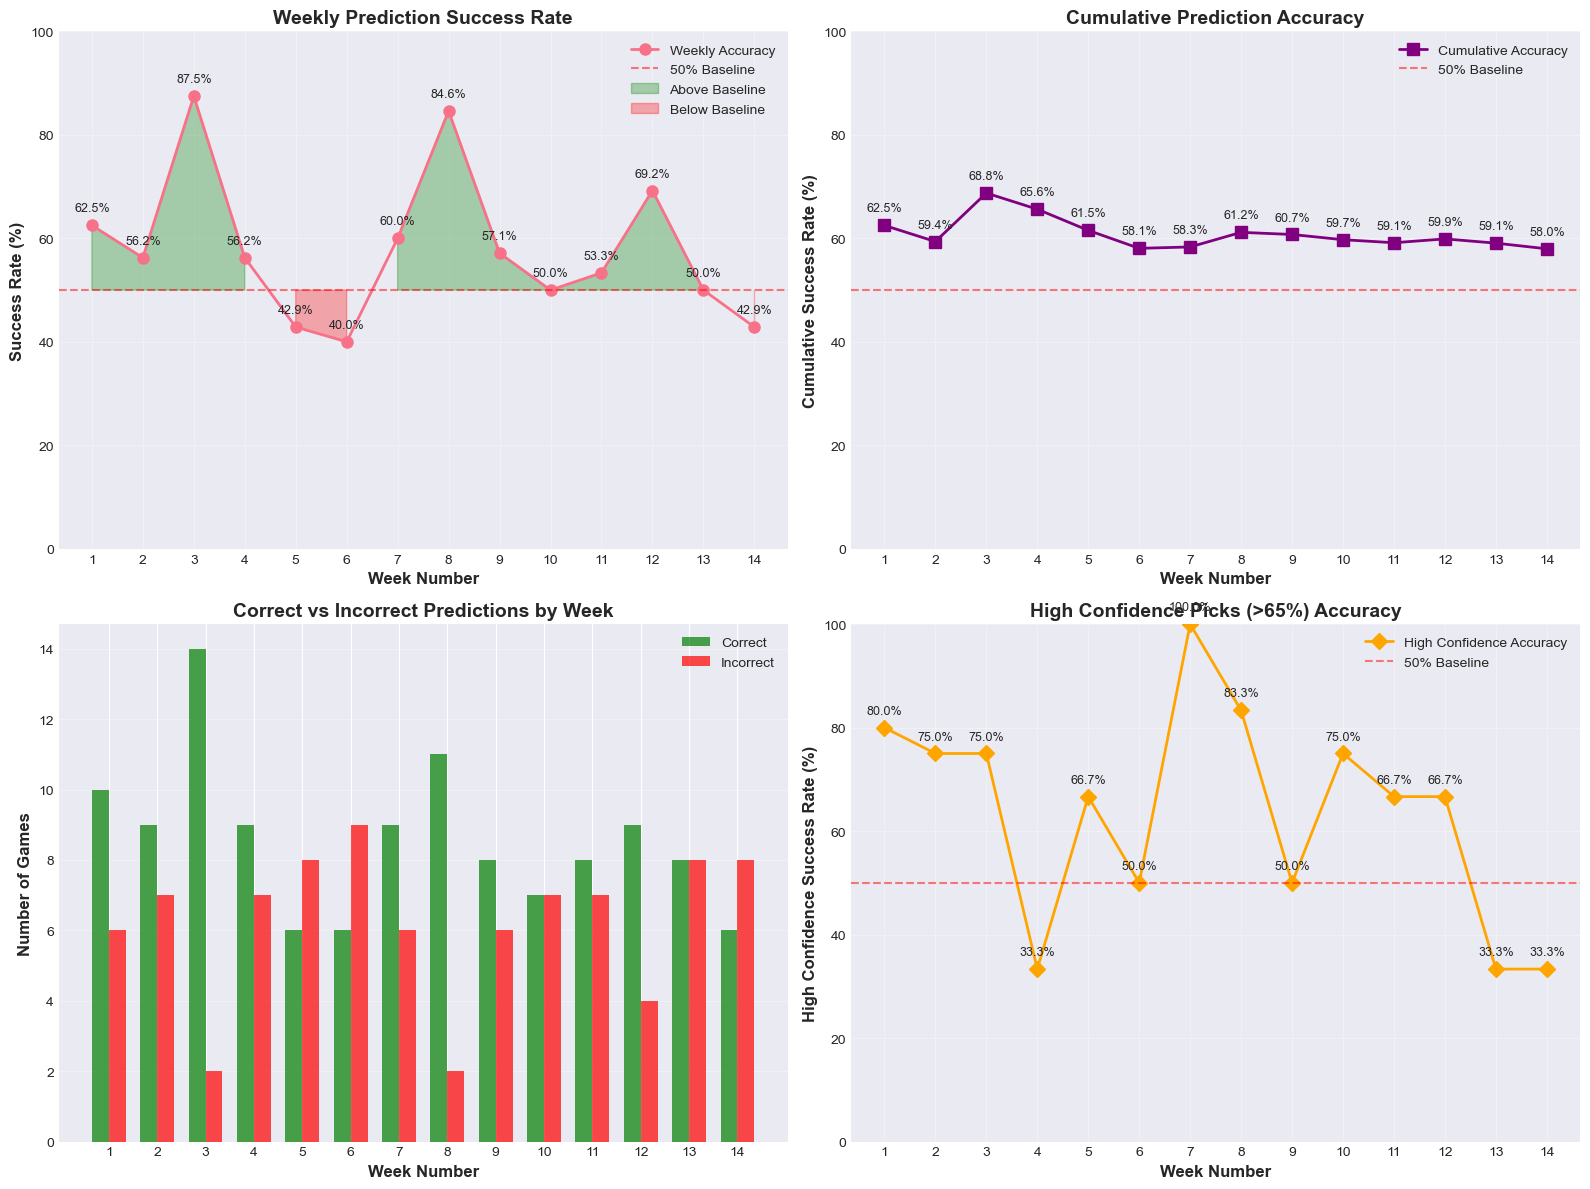


 Plots generated successfully!


In [8]:
# Plot 1: Success Rate Over Weeks
if all_stats and len(all_stats) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Weekly Accuracy (Success Rate)
    ax1 = axes[0, 0]
    ax1.plot(df_stats['Week'], df_stats['Accuracy'], marker='o', linewidth=2, markersize=8, label='Weekly Accuracy')
    ax1.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% Baseline')
    ax1.fill_between(df_stats['Week'], df_stats['Accuracy'], 50, where=(df_stats['Accuracy'] >= 50), 
                     alpha=0.3, color='green', label='Above Baseline')
    ax1.fill_between(df_stats['Week'], df_stats['Accuracy'], 50, where=(df_stats['Accuracy'] < 50), 
                     alpha=0.3, color='red', label='Below Baseline')
    ax1.set_xlabel('Week Number', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Weekly Prediction Success Rate', fontsize=14, fontweight='bold')
    ax1.set_ylim([0, 100])
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xticks(df_stats['Week'])
    
    # Add value labels
    for _, row in df_stats.iterrows():
        ax1.annotate(f"{row['Accuracy']:.1f}%", 
                    (row['Week'], row['Accuracy']),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
    # Plot 2: Cumulative Accuracy
    ax2 = axes[0, 1]
    ax2.plot(df_stats['Week'], df_stats['Cumulative Accuracy'], marker='s', linewidth=2, 
            markersize=8, color='purple', label='Cumulative Accuracy')
    ax2.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% Baseline')
    ax2.set_xlabel('Week Number', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Cumulative Success Rate (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Cumulative Prediction Accuracy', fontsize=14, fontweight='bold')
    ax2.set_ylim([0, 100])
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xticks(df_stats['Week'])
    
    for _, row in df_stats.iterrows():
        ax2.annotate(f"{row['Cumulative Accuracy']:.1f}%", 
                    (row['Week'], row['Cumulative Accuracy']),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
    # Plot 3: Correct vs Incorrect by Week
    ax3 = axes[1, 0]
    x = df_stats['Week']
    width = 0.35
    ax3.bar(x - width/2, df_stats['Correct'], width, label='Correct', color='green', alpha=0.7)
    ax3.bar(x + width/2, df_stats['Incorrect'], width, label='Incorrect', color='red', alpha=0.7)
    ax3.set_xlabel('Week Number', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Number of Games', fontsize=12, fontweight='bold')
    ax3.set_title('Correct vs Incorrect Predictions by Week', fontsize=14, fontweight='bold')
    ax3.set_xticks(df_stats['Week'])
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: High Confidence Accuracy (if available)
    ax4 = axes[1, 1]
    hc_data = df_stats[df_stats['High Conf Accuracy'].notna()]
    if len(hc_data) > 0:
        ax4.plot(hc_data['Week'], hc_data['High Conf Accuracy'], marker='D', linewidth=2, 
                markersize=8, color='orange', label='High Confidence Accuracy')
        ax4.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% Baseline')
        ax4.set_xlabel('Week Number', fontsize=12, fontweight='bold')
        ax4.set_ylabel('High Confidence Success Rate (%)', fontsize=12, fontweight='bold')
        ax4.set_title('High Confidence Picks (>65%) Accuracy', fontsize=14, fontweight='bold')
        ax4.set_ylim([0, 100])
        ax4.set_xticks(df_stats['Week'])
        ax4.grid(True, alpha=0.3)
        ax4.legend()
        
        for _, row in hc_data.iterrows():
            ax4.annotate(f"{row['High Conf Accuracy']:.1f}%", 
                        (row['Week'], row['High Conf Accuracy']),
                        textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    else:
        ax4.text(0.5, 0.5, 'No High Confidence\nPicks Available', 
                ha='center', va='center', fontsize=14, transform=ax4.transAxes)
        ax4.set_title('High Confidence Picks Accuracy', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n Plots generated successfully!")
else:
    print("No data available for plotting.")


In [9]:
# Additional Statistics Table
if all_stats and len(all_stats) > 0:
    print("\n" + "=" * 80)
    print("DETAILED WEEK-BY-WEEK BREAKDOWN")
    print("=" * 80)
    
    for stats in all_stats:
        week = stats['week']
        print(f"\nWeek {week}:")
        print(f"  Total Games: {stats['total_games']}")
        print(f"  Correct: {stats['correct']} ({stats['accuracy']:.1f}%)")
        print(f"  Incorrect: {stats['incorrect']}")
        if stats['high_conf_total'] > 0:
            print(f"  High Confidence Picks: {stats['high_conf_correct']}/{stats['high_conf_total']} ({stats['high_conf_accuracy']:.1f}%)")
        
        # Show individual game results
        print(f"  Game Results:")
        for matchup, result in stats['results'].items():
            status = "✓" if result['correct'] else "✗"
            print(f"    {status} {matchup:<25} Predicted: {result['predicted']:<5} Actual: {result['actual']:<5} ({result['confidence']:.1f}%)")



DETAILED WEEK-BY-WEEK BREAKDOWN

Week 1:
  Total Games: 16
  Correct: 10 (62.5%)
  Incorrect: 6
  High Confidence Picks: 4/5 (80.0%)
  Game Results:
    ✓ DAL @ PHI                 Predicted: PHI   Actual: PHI   (93.5%)
    ✓ KC @ LAC                  Predicted: LAC   Actual: LAC   (63.2%)
    ✓ TB @ ATL                  Predicted: TB    Actual: TB    (53.7%)
    ✓ CIN @ CLE                 Predicted: CIN   Actual: CIN   (58.3%)
    ✓ MIA @ IND                 Predicted: IND   Actual: IND   (62.8%)
    ✓ CAR @ JAX                 Predicted: JAX   Actual: JAX   (67.3%)
    ✗ LV @ NE                   Predicted: NE    Actual: LV    (51.5%)
    ✗ ARI @ NO                  Predicted: NO    Actual: ARI   (64.1%)
    ✗ PIT @ NYJ                 Predicted: NYJ   Actual: PIT   (74.9%)
    ✓ NYG @ WAS                 Predicted: WAS   Actual: WAS   (66.2%)
    ✓ TEN @ DEN                 Predicted: DEN   Actual: DEN   (72.1%)
    ✗ SF @ SEA                  Predicted: SEA   Actual: SF    (51.5%

In [10]:
# OPTIONAL: Save predictions to CSV files for future use
# Run this cell after you've executed predictions in each Model.ipynb
# This saves predictions so they can be loaded even in different Jupyter sessions

def save_week_predictions_to_csv(week_num):
    """Save predictions for a specific week to CSV if available in globals."""
    week_dir = os.path.join(BASE_DIR, f"Week{week_num}")
    csv_file = os.path.join(week_dir, f"week{week_num}_predictions.csv")
    
    # Try both variable naming conventions
    predictions_var_spread = f"week{week_num}_spread_results"
    predictions_var_regular = f"week{week_num}_results"
    
    predictions_df = None
    
    # Check globals
    if predictions_var_spread in globals():
        predictions_df = globals()[predictions_var_spread]
    elif predictions_var_regular in globals():
        predictions_df = globals()[predictions_var_regular]
    
    if predictions_df is not None and isinstance(predictions_df, pd.DataFrame):
        try:
            predictions_df.to_csv(csv_file, index=False)
            print(f"✓ Week {week_num}: Saved {len(predictions_df)} predictions to CSV")
            return True
        except Exception as e:
            print(f"✗ Week {week_num}: Error saving to CSV: {e}")
            return False
    else:
        print(f"⚠ Week {week_num}: No predictions variable found")
        return False

def save_all_weeks_to_csv():
    """Save predictions for all weeks 1 through MAX_WEEK to CSV files."""
    print("Saving predictions to CSV files...")
    print("=" * 60)
    saved_count = 0
    for week_num in range(1, MAX_WEEK + 1):
        if save_week_predictions_to_csv(week_num):
            saved_count += 1
    
    print("\n" + "=" * 60)
    print(f"Saved {saved_count}/{MAX_WEEK} weeks to CSV files")
    print("These files can now be loaded by Plot.ipynb in any session!")

# Uncomment the line below to save all predictions to CSV:
# save_all_weeks_to_csv()
